# Predicting Usage of a Video Game Research Server - Individual Planning Report

Peti Setabandhu (41047416) - project-004-12

Link to GitHub repo: https://github.com/peteseta/dsci-100-project

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(janitor)
library(GGally)

options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.4.1 ──

✔ broom        1.0.10     ✔ rsample      1.3.1 
✔ dials        1.4.2      ✔ tailor       0.1.0 
✔ infer        1.0.9      ✔ tune         2.0.1 
✔ modeldata    1.5.1      ✔ workflows    1.3.0 
✔ parsnip      1.3.3      ✔ workflowsets 1.1.1 
✔ recipes      1.3.1      ✔ yardstick    1.3.2 

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() mask

In [2]:
# load data files
players <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# (1) Data Description:
<!-- Provide a full descriptive summary of the dataset, including information such as the number of observations, summary statistics (report values to 2 decimal places), number of variables, name and type of variables, what the variables mean, any issues you see in the data, any other potential issues related to things you cannot directly see, how the data were collected, etc. Make sure to use bullet point lists or tables to summarize the variables in an easy-to-understand format.

Note that the selected dataset(s) will probably contain more variables than you need. In fact, exploring how the different variables in the dataset affect your model may be a crucial part of the project. You need to summarize the full data regardless of which variables you may choose to use later on. -->

In [3]:
# quick summary of datasets
summary(players)
summary(sessions)

  experience        subscribe       hashedEmail         played_hours    
 Length:196         Mode :logical   Length:196         Min.   :  0.000  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :144       Mode  :character   Median :  0.100  
                                                       Mean   :  5.846  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
                                                                        
     name              gender               Age       
 Length:196         Length:196         Min.   : 9.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.00  
                                       Mean   :21.14  
                                       3rd Qu.:22.75  
                                       Max.   :58.00  
                               

 hashedEmail         start_time          end_time         original_start_time
 Length:1535        Length:1535        Length:1535        Min.   :1.712e+12  
 Class :character   Class :character   Class :character   1st Qu.:1.716e+12  
 Mode  :character   Mode  :character   Mode  :character   Median :1.719e+12  
                                                          Mean   :1.719e+12  
                                                          3rd Qu.:1.722e+12  
                                                          Max.   :1.727e+12  
                                                                             
 original_end_time  
 Min.   :1.712e+12  
 1st Qu.:1.716e+12  
 Median :1.719e+12  
 Mean   :1.719e+12  
 3rd Qu.:1.722e+12  
 Max.   :1.727e+12  
 NA's   :2          

The data collected from PLAIcraft's experiment is split into two datasets: `players.csv` and `sessions.csv`. 
- The `players.csv` dataset contains demographic and aggregate play information about each registered player
- The `sessions.csv` dataset records individual gaming sessions (noting their start and end times), linked to each player by their hashed email.

### Players dataset
(196 players x 7 variables)

| Variable | Type | Description |
|---------------|------|-------------|
| `experience` | Categorical (Factor) | Player experience level, one of "Beginner", "Amateur", "Regular", "Pro", or "Veteran" |
| `subscribe` | Logical (Boolean) | Whether the player subscribes to a game-related newsletter |
| `hashedEmail` | Character | Identifier based on the player's email |
| `played_hours` | Numeric (Double) | Total hours played on the server |
| `name` | Character | Player name | 
| `gender` | Categorical (Factor) | Player gender identity |
| `Age` | Numeric (Integer) | Player age in years |

### Sessions dataset
(1,535 gaming sessions x 5 variables)

| Variable | Type | Description |
|---------------|------|-------------|
| `hashedEmail` | Character | Identifier based on the player's email, matches players dataset |
| `start_time` | Character | Session start time (as DD/MM/YYYY HH:MM) |
| `end_time` | Character | Session end time (as DD/MM/YYYY HH:MM) |
| `original_start_time` | Character | Session start time (as unix time) |
| `original_end_time` | Character | Session end time (as unix time) |

### Summary statistics
- **Played hours:** Many players registered and did not play at all, with the player who played the most recording 223.1 hours. The average player played for 5.85 hours.
- **Age:** The youngest player was 9 and the oldest player was 58, with the average player being 21.14 years old
- **Distribution of player experience levels:**
    <table class="dataframe">
    <thead>
        <tr><th scope=col>Experience level</th><th scope=col>Number of players</th></tr>
    </thead>
    <tbody>
        <tr><td>Beginner</td><td>35</td></tr>
        <tr><td>Amateur </td><td>63</td></tr>
        <tr><td>Regular </td><td>36</td></tr>
        <tr><td>Pro     </td><td>14</td></tr>
        <tr><td>Veteran </td><td>48</td></tr>
    </tbody>
    </table>

### Data quality
- There are some missing values. For instance, the `age` variable contains at least one NA value in the last row
- Many players have 0 recorded play hours, indicating they registered but did not play at all (so there are many players with no corresponding sessions in the sessions dataset)

### Other potential issues
- If there are a lot of missing values, this may bias the analysis
- Time period: the sessions dataset ranges from about April 6, 2024 to September 26, 2024, so any temporal trends outside this period cannot be captured (for instance seasonal patterns over the new years or summer vs. winter)
- There is also a privacy consideration - although the emails are hashed, we have the names of the players and their age/gender

# (2) Questions:
<!-- Clearly state one broad question that you will address, and the specific question that you have formulated. Your question should involve one response variable of interest and one or more explanatory variables, and should be stated as a question. One common question format is: “Can [explanatory variable(s)] predict [response variable] in [dataset]?”, but you are free to format your question as you choose so long as it is clear. Describe clearly how the data will help you address the question of interest. You may need to describe how you plan to wrangle your data to get it into a form where you can apply one of the predictive methods from this class. -->

The **broad question** I will address is:
> Question 2: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

The **specific question** I will focus on is: 
> Can player demographic and experience level predict the total hours played on the PLAIcraft server?

Demograhphic information like age, gender, and experience level (from the `players.csv` dataset) may influence how much time a player spends on the server (measured by the `played_hours` variable). By analyzing these relationships, we can identify whether a potential player is likely to contribute significant playtime, allowing PLAIcraft to focus their recruitment efforts on the most valuable players.

To answer this question, I will primarily use the `players.csv` dataset. The response variable will be `played_hours`, and the predictor variables will include `experience`, `gender`, `subscribe`, and `Age`. Name and hashedEmail will not be used as predictors as they are identifiers and have no causal relationship with playtime. I'll need to wrangle the data to ensure that categorical variables like `experience` and `gender` are properly formatted as factors for modeling. I'll also need to handle missing values in the predictor variables, as well as consider how to treat players with 0 recorded play hours in the analysis. I can then use a regression method like K-NN regression or linear regression to model the relationship between the predictors and the response variable.

# (3) Exploratory Data Analysis and Visualization
<!-- In this assignment, you will:

- Demonstrate that the dataset can be loaded into R.
- Do the minimum necessary wrangling to turn your data into a tidy format. Do not do any additional wrangling here; that will happen later during the group project phase.
- Compute the mean value for each quantitative variable in the players.csv data set. Report the mean values in a table format.
- Make a few exploratory visualizations of the data to help you understand it.
Use our visualization best practices to make high-quality plots (make sure to include labels, titles, units of measurement, etc)
- Explain any insights you gain from these plots that are relevant to address your question -->

In [4]:
# clean data
players <- players |>
    clean_names() |>
    mutate(experience = factor(experience, levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran")), 
    gender = factor(gender))

sessions <- sessions |>
    clean_names() |>
    select(-original_start_time, -original_end_time) # epoch already converted for us, so these are redundant

players
sessions

experience,subscribe,hashed_email,played_hours,name,gender,age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


hashed_email,start_time,end_time
<chr>,<chr>,<chr>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57
⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45


In [5]:
# summary stats on players
players_stats <- players |>
    summarise(avg_played_hours = mean(played_hours, na.rm = TRUE),
              avg_age = mean(age, na.rm = TRUE))

players_stats

# count of each experience factor
players_experience_count <- players |>
    count(experience)

players_experience_count

avg_played_hours,avg_age
<dbl>,<dbl>
5.845918,21.13918


experience,n
<fct>,<int>
Beginner,35
Amateur,63
Regular,36
Pro,14
Veteran,48


Warning message:
“Removed 2 rows containing missing values”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
`stat_bin()` using `bins = 30`. Pick better value `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value `binwidth`.
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


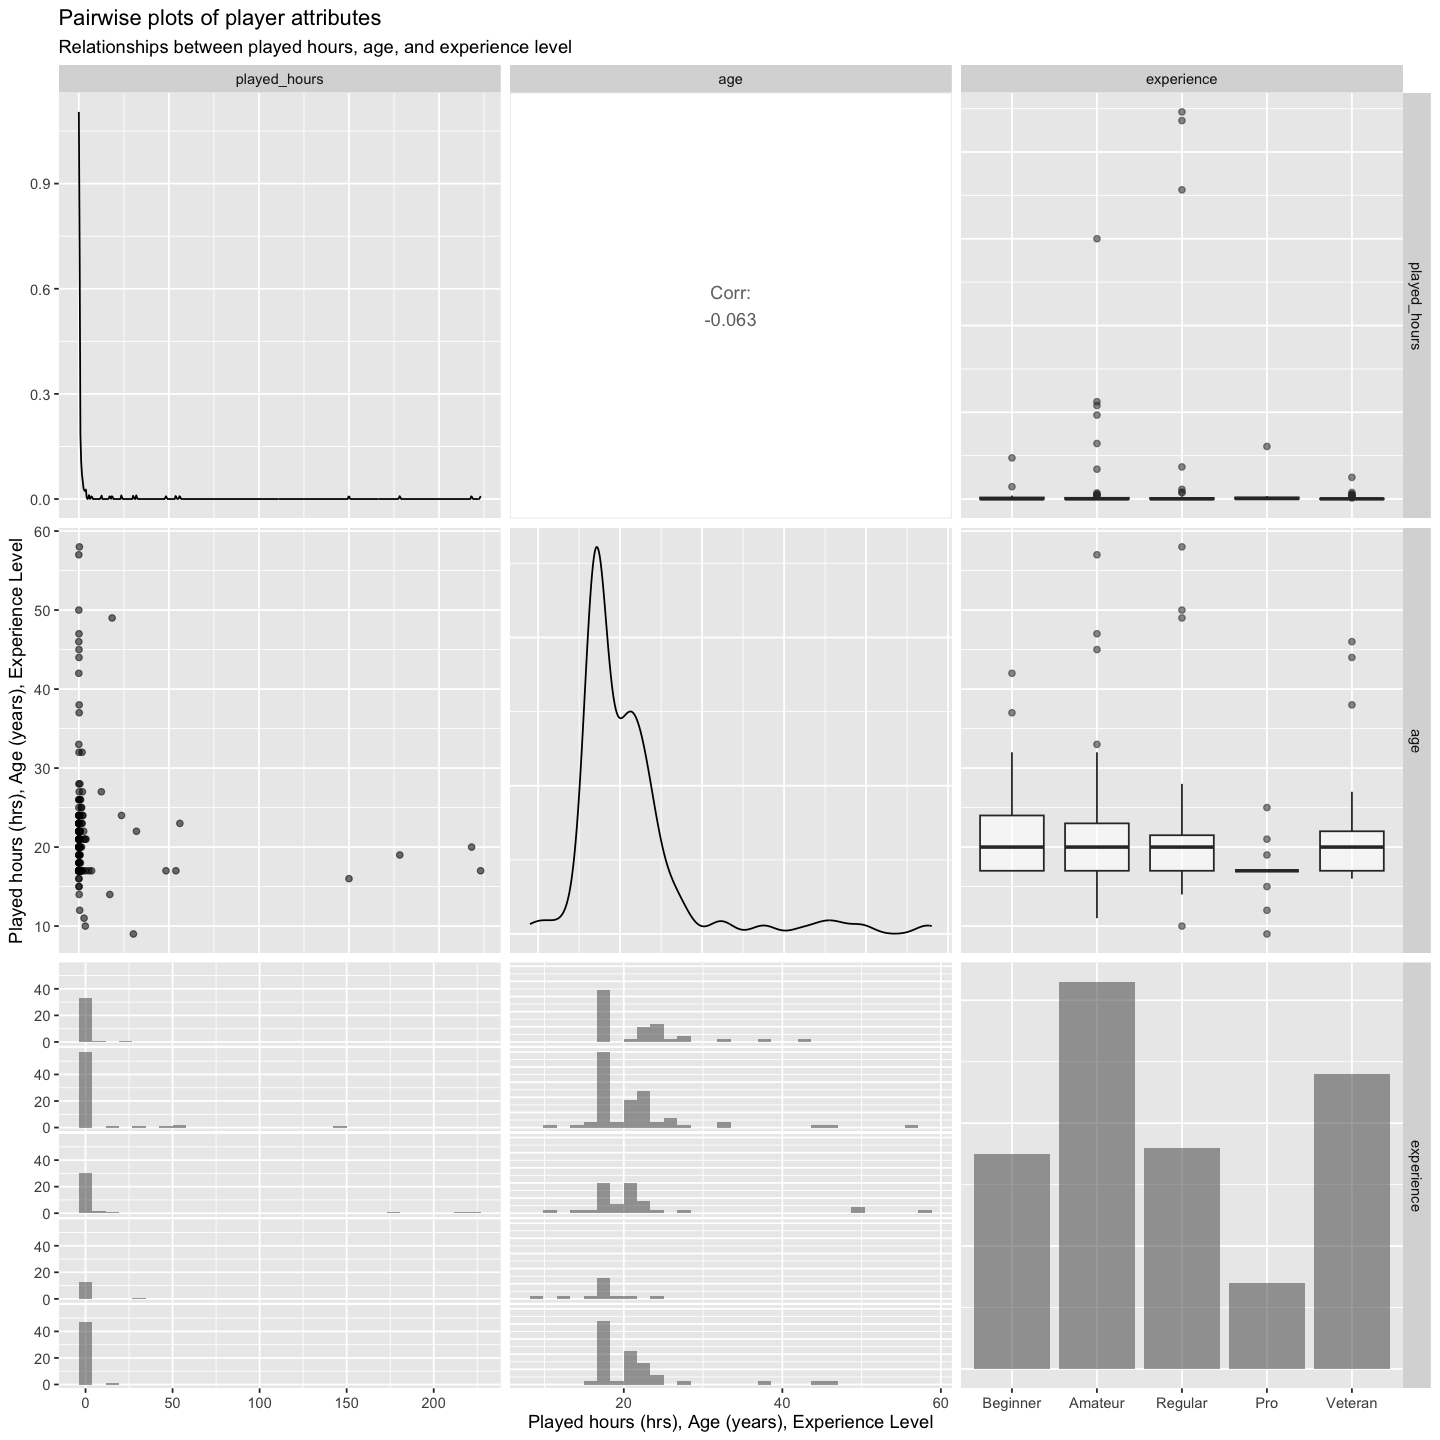

In [8]:
# preliminary visualization - pairplot
options(repr.plot.width = 12, repr.plot.height = 12)

players_pairs <- players |>
    select(played_hours, age, experience) |>
    ggpairs(mapping = aes(alpha = 0.4)) +
    labs(title = "Pairwise plots of player attributes",
         subtitle = "Relationships between played hours, age, and experience level",
         x = "Played hours (hrs), Age (years), Experience Level",
         y = "Played hours (hrs), Age (years), Experience Level")

players_pairs

- The modal experience level is "Amateur", followed by "Veteran." This doesn't change much with age, but the variation (IQR) of ages within the "Pro" experience level is much smaller than other levels, indicating that most "Pro" players are within a similar age range.
- The outliers in played hours are mostly within the 15-20 age range
  - Everyone above the age of 25 played fewer than 25 hours on the server, with most close to or at 0 hours.
  - Interestingly, these outliers also rated themselves as "Amateur" or "Regular" experience level, rather than "Pro" or "Veteran."

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


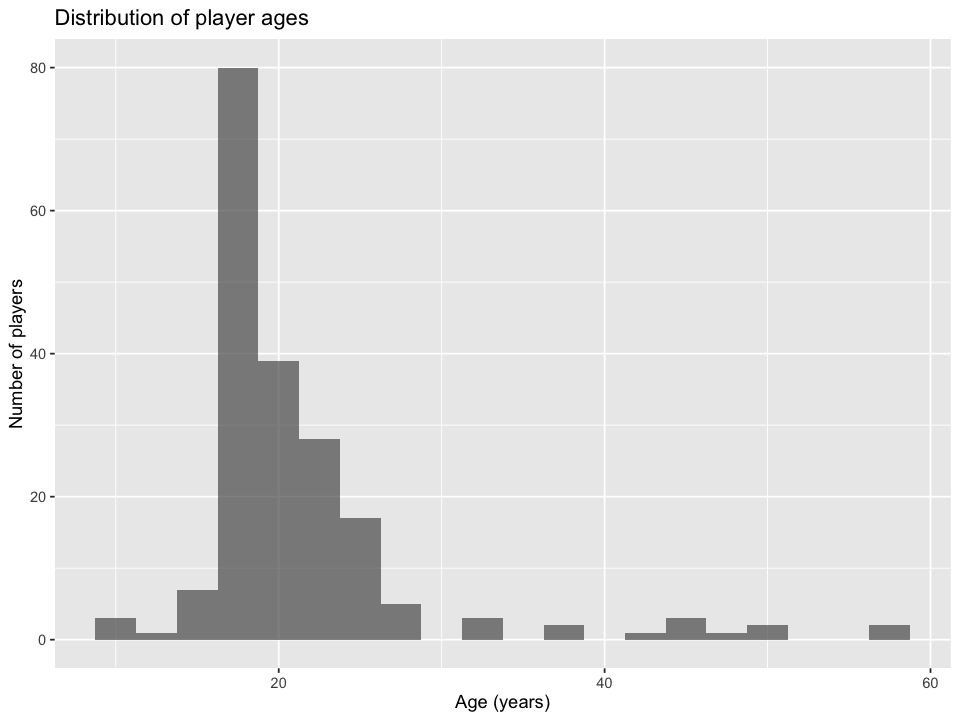

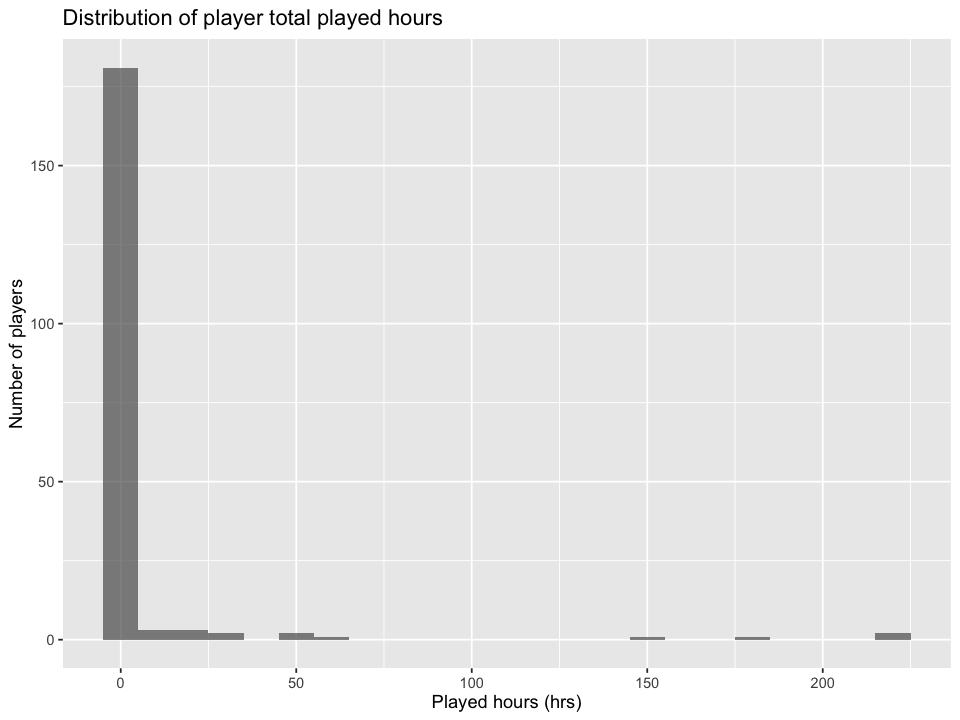

In [ ]:
# preliminary visualization - distribution of age of players
options(repr.plot.width = 8, repr.plot.height = 6)
players_ages <- players |>
    ggplot(aes(x = age)) +
    geom_histogram(binwidth = 2.5, alpha = 0.7) +
    labs(title = "Distribution of player ages",
         x = "Age (years)",
         y = "Number of players")

players_ages

# preliminary visualization - distribution of played hours
players_played_hours <- players |>
    ggplot(aes(x = played_hours)) +
    geom_histogram(binwidth = 10, alpha = 0.7) +
    labs(title = "Distribution of player total played hours",
         x = "Played hours (hrs)",
         y = "Number of players")

players_played_hours

- Most players are around 15-25 in age, with a few older and younger outliers. This could suggest that most players are high school or university students.
- By far the modal bin for played hours is 0, indicating many players registered but did not play at all. There are a few outliers, with small numbers of players playing for very long durations over the course of the study.

# (4) Methods and Plan
<!-- Propose one method to address your question of interest using the selected dataset and explain why it was chosen. Do not perform any modelling or present results at this stage. We are looking for high-level planning regarding model choice and justifying that choice.

In your explanation, respond to the following questions:

Why is this method appropriate?
Which assumptions are required, if any, to apply the method selected?
What are the potential limitations or weaknesses of the method selected?
How are you going to compare and select the model?
How are you going to process the data to apply the model? For example: Are you splitting the data? How? How many splits? What proportions will you use for the splits? At what stage will you split? Will there be a validation set? Will you use cross validation? -->